In [1]:
import numpy as np
#from scipy.special import comb
from scipy import integrate
from scipy.stats import ttest_rel
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os
from math import sqrt
from math import floor
import json
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import ConnectionPatch
import multiprocessing as mp
import numba as nb
import time

In [2]:
plt.rcParams['font.sans-serif'] = 'Times New Roman'

In [3]:
comb = np.array([[1,0,0,0,0],[1,1,0,0,0],[1,2,1,0,0],[1,3,3,1,0],[1,4,6,4,1]])

def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.

    Based on https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    and probably on the 1998 thesis by Tim Andrew Pastva, "Bézier Curve Fitting".
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        return t ** k * (1 - t) ** (n - k) * comb[n][k]
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

In [4]:
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb[n][i] * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(points, nTimes=50):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

[[19.2127, -100.14895], [19.21238872750056, -100.14817330156941], [19.21278263030572, -100.14807873735143], [19.21342, -100.1482]]


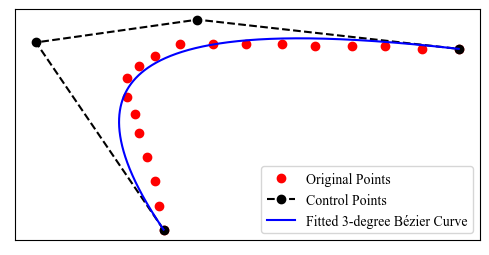

In [5]:
points = []
xpoints = [19.21270, 19.21269, 19.21268, 19.21266, 19.21264, 19.21263, 19.21261, 19.21261, 19.21264, 19.21268,19.21274, 19.21282, 19.21290, 19.21299, 19.21307, 19.21316, 19.21324, 19.21333, 19.21342]
ypoints = [-100.14895, -100.14885, -100.14875, -100.14865, -100.14855, -100.14847, -100.14840, -100.14832, -100.14827, -100.14823, -100.14818, -100.14818, -100.14818, -100.14818, -100.14819, -100.14819, -100.14819, -100.14820, -100.14820]
for i in range(len(xpoints)):
    points.append([xpoints[i],ypoints[i]])
    
degree = 3
fig = plt.figure(figsize=(6,3))
# Plot the original points
plt.plot(xpoints, ypoints, "ro",label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, degree=degree)
x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
print(data)
# Plot the control points
plt.plot(x_val,y_val,'k--o', label='Control Points')
# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
plt.plot(xvals, yvals, 'b-', label=f'Fitted {degree}-degree Bézier Curve')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

fig.savefig('bezier-1.pdf', bbox_inches='tight')

In [6]:
dires = [(-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]
dires = [np.array(x) for x in dires]

def dfs_conn(p, mp):
    mp[p[0]][p[1]] = 255
    
    for dire in dires:
        new_p = p + dire
        if new_p[0] >= 0 and new_p[0] < mp.shape[0] and new_p[1] >= 0 and new_p[1] < mp.shape[1] and mp[new_p[0]][new_p[1]] == 0:
            dfs_conn(new_p, mp)


def conn_comp(mp, sig):
    """
    Calculate the number of connected components.
    """
    mp = mp.copy()
    num = 0
    for i in range(sig.shape[0]):
        if mp[sig[i][0]][sig[i][1]] == 0:
                dfs_conn(sig[i], mp)
                num += 1
    return num

def dr(t, rx, ry):
    '''
    Compute r'(t)
    '''
    tt = t * t
    rt = np.array([1, -1, 2*t, -4*t, 2*t, -tt, 3*tt, -3*tt, tt])
#     rx = np.array([x2, x1, x1, x2, x3, x1, x2, x3, x4])
#     ry = np.array([y2, y1, y1, y2, y3, y1, y2, y3, y4])
    r1 = np.dot(rt, rx)
    r2 = np.dot(rt, ry)
    return r1, r2

def atan_r(t, rx, ry):
    """
    Compute the degree of tangent of B3 by point
    i.e. arctan(dy/dx(t))
    """
    return np.arctan2(*dr(t, rx, ry))

def ds(t, rx, ry):
    """
    Compute element of arc lengthof B3 by t
    i.e. ds = |r'(t)| dt
    """
    r1, r2 = dr(t, rx, ry)
    return sqrt(r1 * r1 + r2 * r2)

def kr(t, c1, c2, c3, rx, ry):
    """
    Compute reletive curvature element of B3 by arc-length parameterization s
    i.e. kr(s) ds = kr(s(t))|r'(t)| dt
    
    We introduce c1, c2, c3, rx, ry in order to fasten the computation
    """
    r = ds(t, rx, ry)
    tt = t * t
    return (c1 + tt*c2 + t*c3) / (r * r)
#     x12 = x1-x2
#     y12 = y1-y2
#     return 18*(x1*(y2-y3) + x2*(y3-y1) + x3*y12\
#                + tt*(x1*(y2+y4) - (x2+x4)*y1 + x3*y4 - x4*y3\
#                + 2*(-x1*y3 + x3*y1 - x2*y4 + x4*y2) + 3*(x2*y3 - x3*y2))\
#                + t*(2*(-x1*y2 + x2*y1) + 3*(x12*y3 - x3*y12) - x12*y4 + x4*y12))\
#                / (r * r)

def k(t, c1, c2, c3, rx, ry):
    """
    Compute curvature element of B3 by arc-length parameterization s
    i.e. k(s) ds = k(s(t))|r'(t)| dt = |kr(s(t))r'(t)| dt
    """

    return abs(kr(t, c1, c2, c3, rx, ry))

def k_para(p):
    p0, p1, p2, p3 = p
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = p2
    x4, y4 = p3
    
    x12 = x1-x2
    y12 = y1-y2
    c1 = x1*(y2-y3) + x2*(y3-y1) + x3*y12
    c2 = x1*(y2+y4) - (x2+x4)*y1 + x3*y4 - x4*y3\
          + 2*(-x1*y3 + x3*y1 - x2*y4 + x4*y2) + 3*(x2*y3 - x3*y2)
    c3 = 2*(-x1*y2 + x2*y1) + 3*(x12*y3 - x3*y12) - x12*y4 + x4*y12
    return 18*c1, 18*c2, 18*c3

def dr_para(p):
    p0, p1, p2, p3 = p
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = p2
    x4, y4 = p3
    
    rx = np.array([x2, x1, x1, x2, x3, x1, x2, x3, x4])
    ry = np.array([y2, y1, y1, y2, y3, y1, y2, y3, y4])
    return 3 * rx, 3 * ry

def mean_curv(p):
    p0, p1, p2, p3 = p
    c1, c2, c3 = k_para(p)
    rx, ry = dr_para(p)
    arc_len, err = integrate.quad(ds, 0, 1, args=(rx, ry)) # Length of arc
    total_curv, err = integrate.quad(k, 0, 1, args=(c1, c2, c3, rx, ry))    # Sum of curvature
    
    return total_curv, arc_len

def winding_deg(p):
    p0, p1, p2, p3 = p
    c1, c2, c3 = k_para(p)
    rx, ry = dr_para(p)
    deg, err = integrate.quad(k, 0, 1, args=(c1, c2, c3, rx, ry))
    
    return deg

def dfs_nearpoint(p, mp, near_set, bs):
    mp[p[0]][p[1]] = 255
    near_set.append(p)
    next_pos = []
    
    for dire in dires:
        if len(near_set) == bs:
            next_pos.append(p)
            break
        new_p = p + dire
        if new_p[0] >= 0 and new_p[0] < mp.shape[0] and new_p[1] >= 0 and new_p[1] < mp.shape[1] and mp[new_p[0]][new_p[1]] == 0:
            next_pos.extend(dfs_nearpoint(new_p, mp, near_set, bs))
    return next_pos

def find_nearpoint(mp, bs):
    mp = mp.copy()
    near_sets = []
    next_pos = []
    for i in range(mp.shape[0]):
        for j in range(mp.shape[1]):
            if mp[i][j] == 0:
                next_pos.append(np.array((i, j)))
                while len(next_pos) > 0:
                    near_set = []
                    r, c = next_pos[-1]; next_pos.pop()
                    
                    next_pos.extend(dfs_nearpoint(np.array((r, c)), mp, near_set, bs))
                    if 5 <= len(near_set) <= bs:
                        near_sets.append(near_set)
            
    return near_sets
                          
print(mean_curv(np.array([(183, 62), (180.88468013467988, 64.33333333333323), (182.5875420875422, 66.66666666666671), (182, 69)])))
print(winding_deg(np.array([(183, 62), (180.88468013467988, 64.33333333333323), (182.5875420875422, 66.66666666666671), (182, 69)])))

0.16634951391742395
1.214559814329326


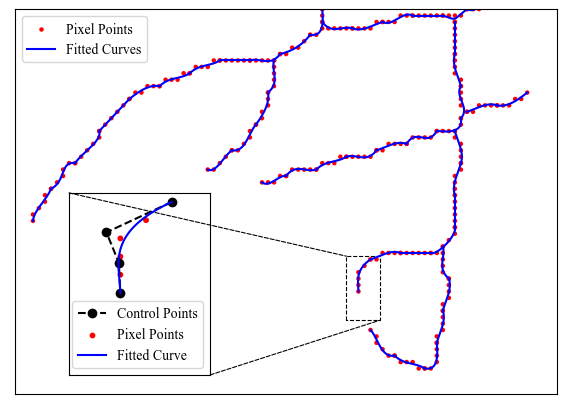

In [7]:
im = cv2.imread('./pre/1/1.png', cv2.IMREAD_GRAYSCALE)

points = []
bd = im.shape[0]
bs = 6
deg = 3

dires = [(-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]
dires = [np.array(x) for x in dires]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
subax = ax.inset_axes((0.1, 0.05, 0.26, 10/5.5 * 0.26))

mark_x = [175, 175, 180.5, 180.5, 175]
mark_y = [148.5, 138.5, 138.5, 148.5, 148.5]
ax.plot(mark_x, mark_y, 'black', linewidth=0.8, linestyle='dashed')

con = ConnectionPatch(xyA=(175, 138.5),xyB=(175, 138.5),coordsA="data",coordsB="data",
        axesA=subax,axesB=ax, linestyle='dashed', linewidth=0.8)
subax.add_artist(con)
con = ConnectionPatch(xyA=(180.5, 148.5),xyB=(180.5, 148.5),coordsA="data",coordsB="data",
        axesA=subax,axesB=ax, linestyle='dashed', linewidth=0.8)
subax.add_artist(con)

near_sets = find_nearpoint(im, bs)
for near_set in near_sets:
        accepted = True
        for pts in near_set:
            if pts[1] < 176 or pts[1] > 181.5 or pts[0] < 138.5 or pts[0] > 148.5:
                accepted = False
        near_set  = np.array(near_set)
        near_xpts = near_set[:,0]
        near_ypts = near_set[:,1]
        data = get_bezier_parameters(near_ypts, near_xpts, degree=deg)
        x_val = [x[0] for x in data]
        y_val = [x[1] for x in data]
        xvals, yvals = bezier_curve(data, nTimes=1000)
        ax.scatter(near_ypts, near_xpts, c="r", s = [5]*len(near_xpts))
        ax.plot(xvals, yvals, 'b-')
        
        if accepted:
            subax.plot(x_val,y_val,'k--o', label='Control Points')
            subax.scatter(near_ypts, near_xpts, c="r", s = [10]*len(near_xpts), label='Pixel Points')
            subax.plot(xvals, yvals, 'b-', label='Fitted Curve')
            
ax.scatter(near_ypts, near_xpts, c="r", s = [5]*len(near_xpts), label='Pixel Points')
ax.plot(xvals, yvals, 'b-', label='Fitted Curves')

ax.set_xlim((120, 210))
ax.set_ylim((160, 100))
ax.set_xticks([])
ax.set_yticks([])

subax.set_xlim((175, 180.5))
subax.set_ylim((148.5, 138.5))
subax.set_xticks([])
subax.set_yticks([])

ax.legend(loc='upper left')
subax.legend(loc='lower right')
plt.show()
fig.savefig('bezier-2.pdf', bbox_inches='tight')